# Explore the [Titanic dataset](https://www.kaggle.com/c/titanic) from Kaggle

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = "16"

Dataset is read from the `classification` folder, which also includes the instructions for loading the dataset from Kaggle.

In [2]:
train = pd.read_csv('../classification/kaggle_titanic_dataset/train.csv')
test = pd.read_csv('../classification/kaggle_titanic_dataset/test.csv')
n_train, m_train = train.shape

data_orig = train.copy()
# Assume that PassengerId and Name do not matter
X_train = train.drop(['PassengerId', 'Survived', 'Name'], axis=1)
y_train = train['Survived'].values

Check the first values of the `DataFrame`:

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Numeric columns can be summarized with the `describe()` method:

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Description shows that 180 ages are missing and some of the fares are zero. Check the number of those:

In [5]:
print('Number of zero fare values:', np.sum(train['Fare'] == 0.0))

Number of zero fare values: 15


Check the survivor numbers:

In [6]:
print('--Survived--')
print(train["Survived"].value_counts())

--Survived--
0    549
1    342
Name: Survived, dtype: int64


Let us convert `Sex` and `Embarked` categoricals to one-hot encoding and also add an indicator for missing `Age` field. These operations are done using `sklearn` transformers.

In [7]:
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 

class MissingIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Y = X.copy()
        Y.loc[:, '%s_missing' % self.column_name] = np.isnan(Y[self.column_name]).astype('float64')
        return Y
    
class CategoricalOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, max_categories=5, columns=None, drop_first=False, astype=None, drop_orig=False):
        self.max_categories = max_categories
        self.categories = []
        self.cols_to_encode = []
        self.drop_first = drop_first
        self.columns = columns
        self.astype = astype
        self.drop_orig = drop_orig
    def fit(self, X, y=None):
        cols = list(X)
        if self.columns is None:
            self.cols_to_encode = [col for col in cols if len(X[col].unique()) <= self.max_categories]
        else:
            self.cols_to_encode = self.columns
        if len(self.cols_to_encode) == 0:
            raise Exception('No categorical attributes to encode that satisfy constraints')
        return self
    def transform(self, X):
        assert len(self.cols_to_encode) > 0
        Y = X.copy()
        if self.drop_orig:
            Y = Y.drop(self.cols_to_encode, axis=1)
        data_to_encode = X[self.cols_to_encode]
        if self.astype is not None:
            data_to_encode = data_to_encode.astype(self.astype)
        df = pd.get_dummies(data_to_encode, drop_first = self.drop_first).astype(np.float64)
        df = df[sorted(df.columns)] # Sort to preserve order
        self.categories = list(df) # Save column order
        return pd.concat([Y, df], axis=1)
    
from sklearn.neighbors import KNeighborsRegressor
    
class DropCategoricals(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.categoricals = list(X.select_dtypes(exclude=['number']))
        return self
    
    def transform(self, X):
        return X.drop(self.categoricals, axis=1)

pipeline1 = Pipeline([
    ('age_indicator', MissingIndicator('Age')),
    ('sex_encoder', CategoricalOneHotEncoder(drop_first=True, columns=['Sex'])),
    ('embarked_encoder', CategoricalOneHotEncoder(drop_first=False, columns=['Embarked']))
])

data = pipeline1.fit_transform(train)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1.0,1.0,0.0,1.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.0,1.0,0.0,0.0,1.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0,1.0,0.0,0.0,1.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0.0,0.0,0.0,0.0,1.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0.0,0.0,1.0,0.0,0.0


## TODO
- Add columns for title
- Impute missing age based on the title
- 

### Plotting correlations

Text(0.5,1,'Correlation of numeric values')

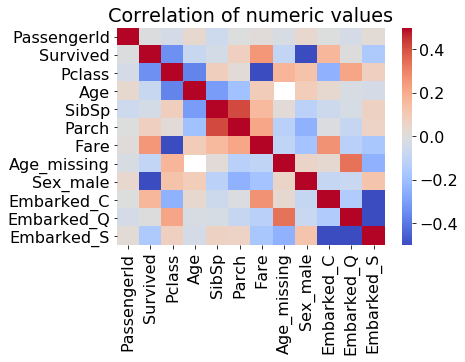

In [8]:
corrs = data.corr()
ax = sns.heatmap(data.corr(),cmap='coolwarm', vmin=-0.5, vmax=0.5)
ax.set_title('Correlation of numeric values')

Barplot of correlations of each column with `Survived`:

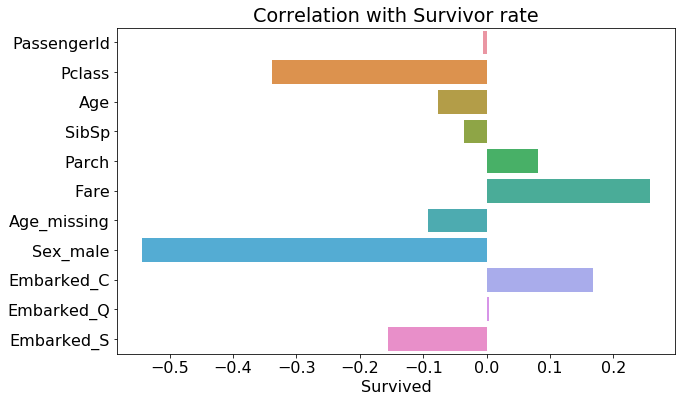

In [9]:
corrs = data.corr().loc['Survived']
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()
corrs = corrs.drop('Survived')
sns.barplot(ax=ax, y=list(corrs.index), x=corrs, orient='h')
ax.set_title('Correlation with Survivor rate')
plt.show()

Let us plot bar plots of the categorical features to see how each affect survival rate:

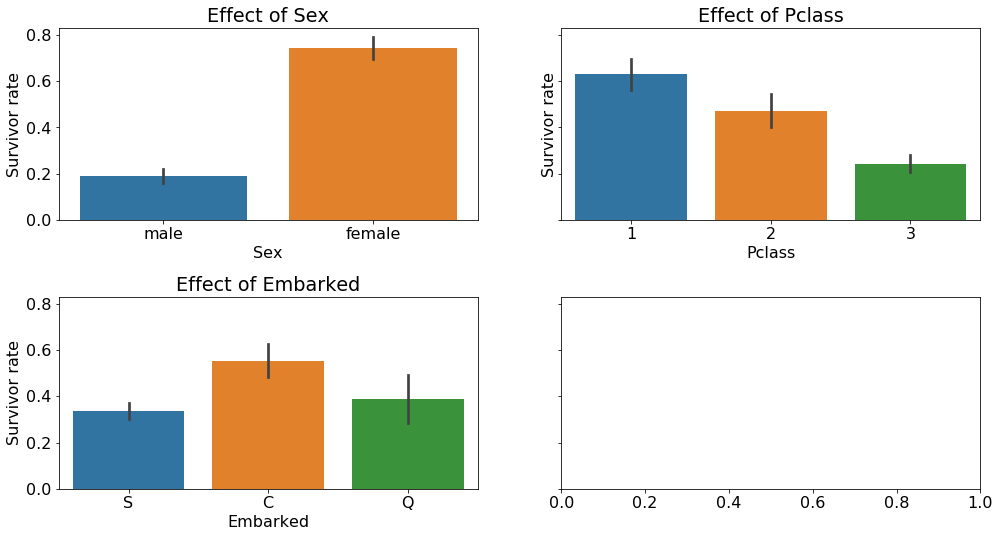

In [10]:
def bar_plot_categorical(ax, column_name, data):
    sns.barplot(ax=ax, x=column_name, y="Survived", data=data)
    ax.set_title('Effect of %s' % column_name)
    ax.set_ylabel("Survivor rate")
    
columns = ['Sex', 'Pclass', 'Embarked']

figw, figh = 16.0, 8.0
fig, axarr = plt.subplots(ncols=2, nrows=2, sharey=True,
                         figsize=(figw, figh))

for ind, col in enumerate(columns):
    ax = np.ravel(axarr)[ind]
    bar_plot_categorical(ax, column_name=col, data=data)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=None, hspace=0.4)
plt.show()

We can gain insight into correlations by splitting survivor rate into more columns:

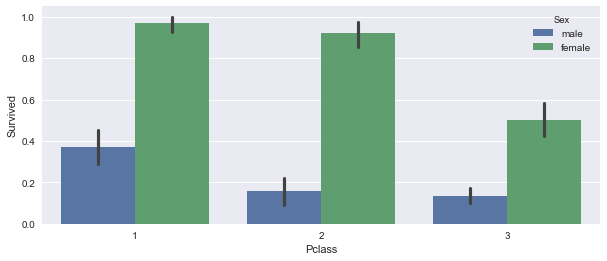

In [11]:
plt.figure(figsize=(10, 4))
plt.style.use('seaborn')
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=data)
plt.show()

Instead of survivor rates, one can also plot counts directly:

Text(0.5,1,'Passenger counts grouped by sex and survival')

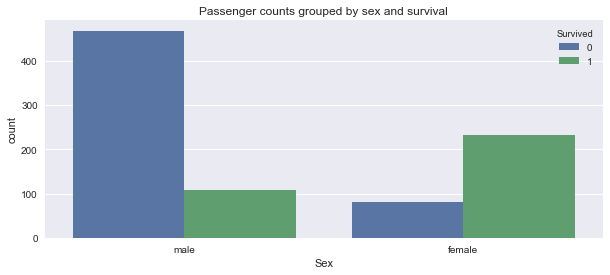

In [12]:
plt.figure(figsize=(10, 4))
plt.style.use('seaborn')
ax = sns.countplot(data=data, x='Sex', hue='Survived')
ax.set_title('Passenger counts grouped by sex and survival')

Text(0.5,1,'Passenger counts grouped by class and survival')

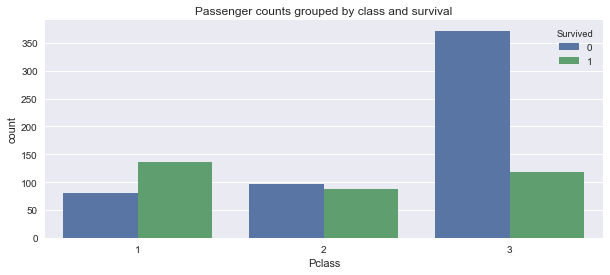

In [13]:
plt.figure(figsize=(10, 4))
plt.style.use('seaborn')
ax = sns.countplot(data=data, x='Pclass', hue='Survived')
ax.set_title('Passenger counts grouped by class and survival')

More complex plots capturing multiple columns can be plotted using `catplot` (requires `seaborn >= 0.9.0`):

<Figure size 720x288 with 0 Axes>

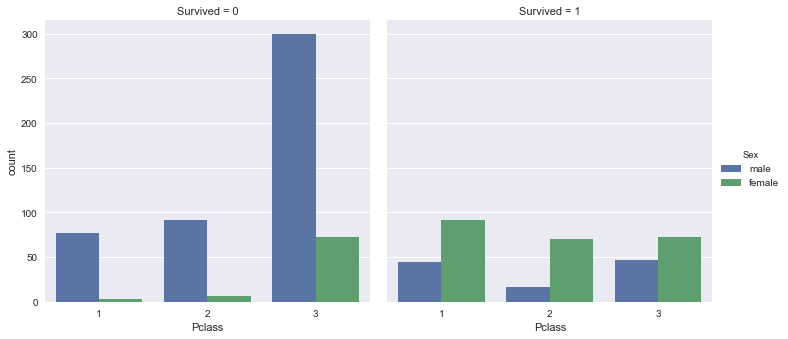

In [14]:
plt.figure(figsize=(10, 4))
plt.style.use('seaborn')
g = sns.catplot(x='Pclass', hue='Sex', col='Survived', data=data, kind='count', height=5);

`sns.distplot` can be used for plotting distributions:

<Figure size 720x576 with 0 Axes>

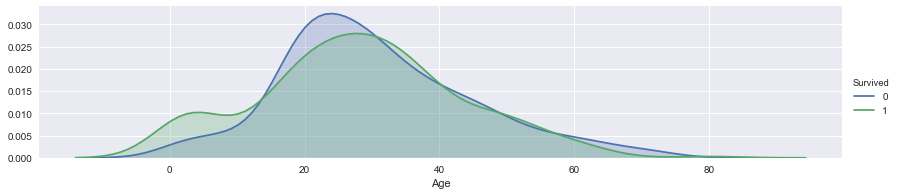

In [15]:
plt.figure(figsize=(10, 8))
g = sns.FacetGrid(data=data, hue='Survived', aspect=4)
g.map(sns.kdeplot, 'Age', shade=True)

plt.style.use('seaborn')
g.add_legend()

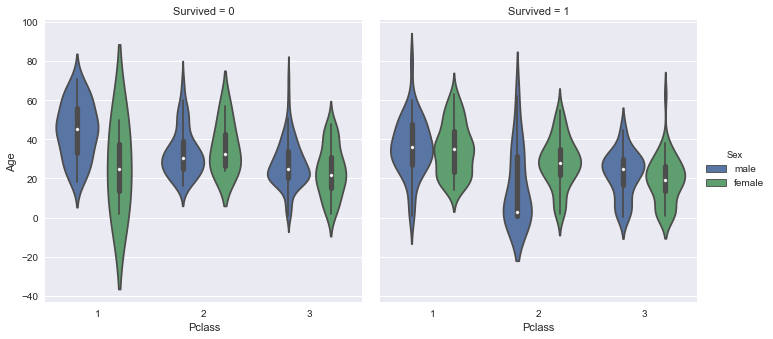

In [16]:
sns.catplot(x="Pclass", y="Age", hue="Sex", kind="violin", sharey=True, data=data, col="Survived");

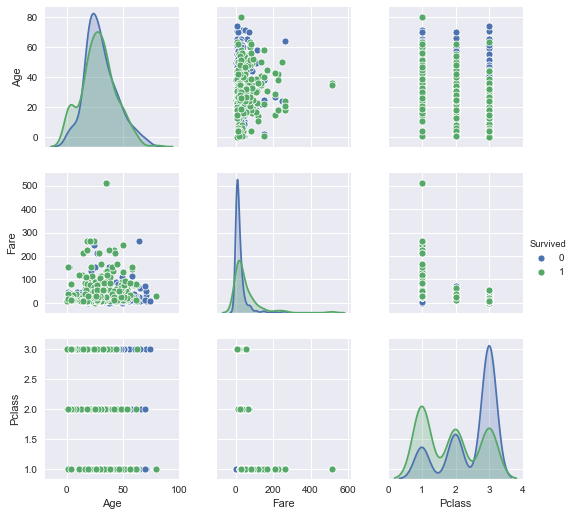

In [17]:
with_age = data[~data['Age'].isnull()]
g = sns.pairplot(data=with_age, hue="Survived", vars=['Age', 'Fare', 'Pclass'], kind='scatter')

<Figure size 720x576 with 0 Axes>

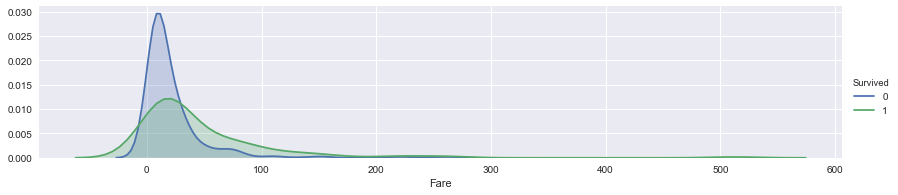

In [18]:
plt.figure(figsize=(10, 8))
g = sns.FacetGrid(data=data, hue='Survived', aspect=4)
g.map(sns.kdeplot, 'Fare', shade=True)

plt.style.use('seaborn')
g.add_legend()

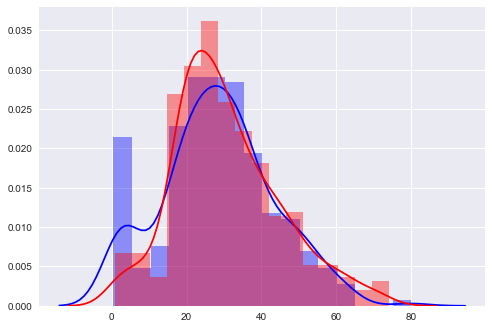

In [19]:
survivors = data[data['Survived'] == 1].copy()
non_survivors = data[data['Survived'] == 0].copy()

survivors_with_age = survivors[~pd.isnull(survivors['Age'])].copy()
non_survivors_with_age = non_survivors[~pd.isnull(non_survivors['Age'])].copy()

sns.distplot(survivors_with_age[['Age']], hist=True, color='b')
sns.distplot(non_survivors_with_age[['Age']], hist=True, color='r')
plt.show()

Plotting multiple columns is easiest using `FacetGrid`:

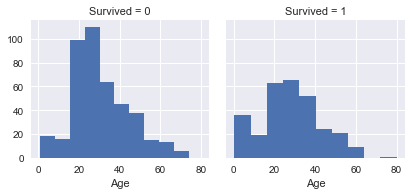

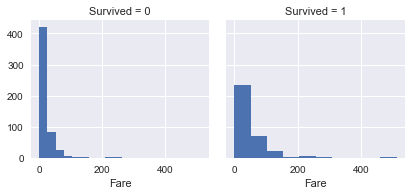

In [20]:
g = sns.FacetGrid(data=data, col='Survived')
g.map(plt.hist, 'Age')
plt.show()

g = sns.FacetGrid(data=data, col='Survived')
g.map(plt.hist, 'Fare')
plt.show()

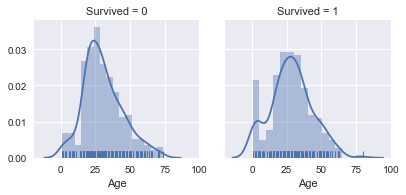

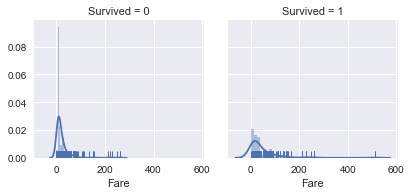

In [21]:
g = lambda col: sns.FacetGrid(data, col=col, palette="Set1")
g('Survived').map(sns.distplot, 'Age', rug=True)
g('Survived').map(sns.distplot, 'Fare', rug=True)
plt.show()